# 22. Phasing of green band formation with respect to insolation
This notebook compares the depositonal ages of green bands to orbital parameters from Laskar's orbital solutions. By comparing the depositional ages of green bands to the ages of insolation maxima in both hemisphere, we can approximate the phasing related to their formation and infer climate processes that might lead to their creation. 

This notebook produces supplementary figure 9.
## Setup
### Import modules

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from matplotlib.ticker import AutoMinorLocator
from scipy import signal,interpolate,stats,linalg
from IPython.display import clear_output
import time
import numpy as np
import seaborn as sns
%matplotlib inline

### Set paths

In [5]:
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
table_path='/Users/danielbabin/GitHub/Green_Bands/Tables/'
core_photos='/Users/danielbabin/GitHub/Green_Bands/CorePhotos/LowRes/'
figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Main/'
sup_figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Supplementary/'
misc_path='/Users/danielbabin/GitHub/Green_Bands/Data/Misc/'

### Import data
#### U1474

In [6]:
green_layers=pd.read_csv(table_path+'Supplementary Table 6A - U1474 green bands.csv')
green_true=green_layers.copy()

In [7]:
am=pd.read_csv(table_path+'Supplementary Table 2 - Age-depth model.csv')
am['Top Interval Depth CCSF (m)']=am['Depth CCSF (m)'].shift(1)
am['Top Interval Age (kyr)']=am['Age (kyr)'].shift(1)
fam=interpolate.interp1d(am['Depth CCSF (m)'],am['Age (kyr)'],bounds_error=False)

In [25]:
green_true['Top Age (kyr)']=fam(green_true['Top Depth CCSF (m)'])
green_true['Bottom Age (kyr)']=fam(green_true['Bottom Depth CCSF (m)'])
agtU1474=green_true[~green_true['Bottom Age (kyr)'].isnull()].set_index('Bottom Age (kyr)',drop=False).sort_index()

#### U1313

In [26]:
green_layers_1313=pd.read_csv(table_path+'Supplementary Table 6B - U1313 green bands.csv')

In [27]:
green_layers_1313['Class']=green_layers_1313['Label']-1
green_true_1313=green_layers_1313[green_layers_1313['Class']>0].copy()

In [28]:
am1313=pd.read_csv(misc_path+'1313_age_model_L*.csv')
fam1313=interpolate.interp1d(am1313['Depth (mcd)'],am1313['Age (ka)'],bounds_error=False)

In [29]:
green_true_1313['Top Age (kyr)']=fam1313(green_true_1313['Top Depth CCSF (m)'])
green_true_1313['Bottom Age (kyr)']=fam1313(green_true_1313['Bottom Depth CCSF (m)'])
agt1313=green_true_1313[~green_true_1313['Top Age (kyr)'].isnull()].set_index('Top Age (kyr)').sort_index()

In [30]:
gs=[[14, 29],[57, 71],[130, 191],[243, 300],[337, 374],[424, 478],[524, 563],[621, 676],
    [712, 761],[790, 814],[866, 900],[917, 936],[959, 970],[982, 1014],[1031, 1062],[1081,1104],
    [1114, 1141],[1190,1215],[1240,1265],[1285,1300],[1320,1344],[1365,1382],[1407,1424],
    [1453,1468],[1494,1510],[1531,1546],[1571,1583],[1642,1669],[1699,1712],[1744,1754],
    [1785,1802],[1860,1871],[1899,1914],[1941,1965],[1996,2016]]

#### Orbital parameters

In [40]:
orb=pd.read_csv(misc_path+'milankovitch.data.csv')
orb['Age (kyr)']=(orb['age']*1000)
orb=orb.set_index('Age (kyr)',drop=False)
orb['pindex']=orb['eccentricity']*np.sin(orb['perihelion'])
orb=orb.loc[0:1500]

#### Insolation

In [45]:
insol30s=pd.read_csv(misc_path+'insolation30N.txt',sep='\s',
                  header=None,engine='python',names=['Age (kyr)','insolation']).astype(float)
insol30s=insol30s.set_index('Age (kyr)')
insol30s['insolation']=(insol30s['insolation']-insol30s['insolation'].mean())*-1+insol30s['insolation'].mean()

insol30n=pd.read_csv(misc_path+'insolation30N.txt',sep='\s',
                  header=None,engine='python',names=['Age (kyr)','insolation']).astype(float)
insol30n=insol30n.set_index('Age (kyr)')
insol65n=pd.read_csv(misc_path+'insolation65N.txt',sep='\s',
                  header=None,engine='python',names=['Age (kyr)','insolation']).astype(float)
insol65n=insol65n.set_index('Age (kyr)')
insol65s=insol65n.copy()
insol65s['insolation']=(insol65s['insolation']-insol65s['insolation'].mean())*-1+insol65s['insolation'].mean()


orb['30S']=insol30s.reindex(orb.index,method='nearest')['insolation'].values
orb['30N']=insol30n.reindex(orb.index,method='nearest')['insolation'].values
orb['65N']=insol65n.reindex(orb.index,method='nearest')['insolation'].values
orb['65S']=insol65s.reindex(orb.index,method='nearest')['insolation'].values

In [33]:
pad_width=20
lpfilt=signal.butter(1,[1/(400+pad_width),1/(400-pad_width)],btype='band',analog=False,output='sos')
filtered=signal.sosfiltfilt(lpfilt,insol30s['insolation'])
insol30s['400kyr']=filtered

## Create green band abundance record
This measures the thickness of green bands in 1 ky intervals

In [34]:
bintest={}

In [35]:
step=1
bin_edges=np.arange(0,5235+step,step,dtype=int)

In [36]:
col_list=['U1474','U1474_C2+', 'U1474_C3', 
          '1313', '1313_C2+', '1313_C3']

In [37]:
records=pd.DataFrame(0,index=bin_edges,columns=col_list)
for i,site in enumerate([agtU1474,agt1313]):
# for i,site in enumerate([agtU1474,agt1313,agt659,agt1143,agt758,agtU1489]):
    sitename=site['Site'].iloc[0]
    nearest=np.round(site.index/step)*step
    site['Nearest']=nearest
    
    thicknesses_total=site.groupby('Nearest').sum(numeric_only=True)['Thickness (cm)']
    thicknesses_c2_plus=site[site['Class']>1].groupby('Nearest').sum(numeric_only=True)['Thickness (cm)']
    thicknesses_c3=site[site['Class']==3].groupby('Nearest').sum(numeric_only=True)['Thickness (cm)']
    records.loc[thicknesses_total.index,str(sitename)]=thicknesses_total.values
    records.loc[thicknesses_c2_plus.index,str(sitename)+'_C2+']=thicknesses_c2_plus.values
    records.loc[thicknesses_c3.index,str(sitename)+'_C3']=thicknesses_c3.values

## Create Phase Wheels
We're testing sensitivity to insolation phasing (north v south) and latitude (30 vs 65)

### Find the dates for insolation maxima

In [46]:
maxes={}
idsmaxes={}
for i in ['30S','30N','65N','65S']:
    maxes[i]=signal.find_peaks(orb[i])[0]
    idsmaxes[i]=orb.iloc[maxes[i]].index

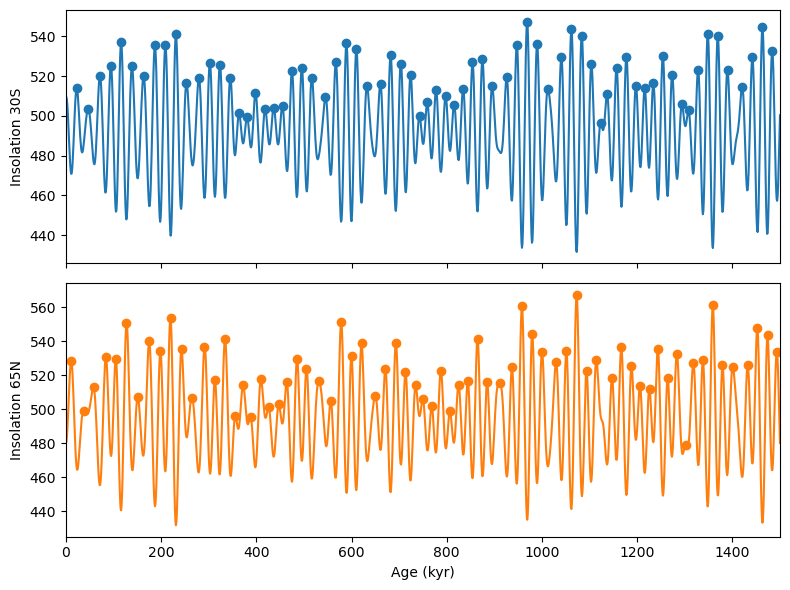

In [47]:
fig,axes=plt.subplots(figsize=(8,6),nrows=2,sharex=True)
ax=axes[0]
key='30S'
orb[key].plot(ax=ax,color='tab:blue')
ax.scatter(orb.iloc[maxes[key]].index,orb.iloc[maxes[key]][key],color='tab:blue')
ax.set_ylabel('Insolation 30S')

ax=axes[1]
key='65N'
orb[key].plot(ax=ax,color='tab:orange')
ax.scatter(orb.iloc[maxes[key]].index,orb.iloc[maxes[key]][key],color='tab:orange')
ax.set_ylabel('Insolation 65N')

ax.set_xlim(0,1500)

plt.tight_layout()

In [48]:
maxnames=['30smax','30nmax','65nmax','65smax']
for i,key in enumerate(['30S','30N','65N','65S']):
    orb[maxnames[i]]=False
    orb.loc[idsmaxes[key],maxnames[i]]=True

In [49]:
maxages={}
for i,key in enumerate(['30S','30N','65N','65S']):
    maxages[key]=orb[orb[maxnames[i]]==True].copy()

### Cycle through green band depositional ages and find nearest insolation maximum
#### U1474

In [50]:
agtU1474['Nearest 30smax Age (kyr)']=np.nan
agtU1474['Nearest 30nmax Age (kyr)']=np.nan
agtU1474['Nearest 65nmax Age (kyr)']=np.nan
agtU1474['Nearest 65smax Age (kyr)']=np.nan
col1names=['Nearest '+name+' Age (kyr)' for name in maxnames]

for i,key in enumerate(['30S','30N','65N','65S']):
    agtU1474.loc[:1500,col1names[i]]=maxages[key].reindex(agtU1474.loc[:1500,'Bottom Age (kyr)'].dropna(),
                                                          method='nearest')['Age (kyr)'].values

#### U1313

In [51]:
agt1313['Nearest 30smax Age (kyr)']=np.nan
agt1313['Nearest 30nmax Age (kyr)']=np.nan
agt1313['Nearest 65nmax Age (kyr)']=np.nan
agt1313['Nearest 65smax Age (kyr)']=np.nan
col1names=['Nearest '+name+' Age (kyr)' for name in maxnames]

for i,key in enumerate(['30S','30N','65N','65S']):
    agt1313.loc[:1500,col1names[i]]=maxages[key].reindex(agt1313.loc[:1500,'Bottom Age (kyr)'].dropna(),
                                                         method='nearest')['Age (kyr)'].values

### Calculate difference between band age and nearest insolation max

In [52]:
col2names=[name+' Proximity' for name in maxnames]
for i,key in enumerate(['30S','30N','65N','65S']):
    agtU1474[col2names[i]]=agtU1474['Bottom Age (kyr)']-agtU1474[col1names[i]]
    agt1313[col2names[i]]=agt1313['Bottom Age (kyr)']-agt1313[col1names[i]]  

### Visualize

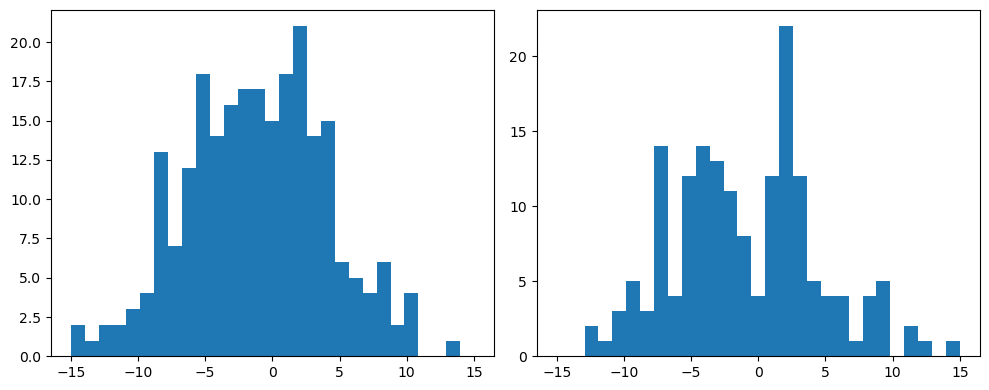

In [53]:
fig,axes=plt.subplots(ncols=2,figsize=(10,4))
bins=np.linspace(-15,15,30)
ax=axes[0]
ax.hist(agtU1474['65smax Proximity'],bins=bins)
ax=axes[1]
ax.hist(agt1313['65smax Proximity'],bins=bins)
plt.tight_layout()

In [54]:
greens_colors=sns.color_palette('Greens')

In [55]:
colorblind=sns.color_palette('colorblind')

In [56]:
colorblind

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

## Visualize as wheel

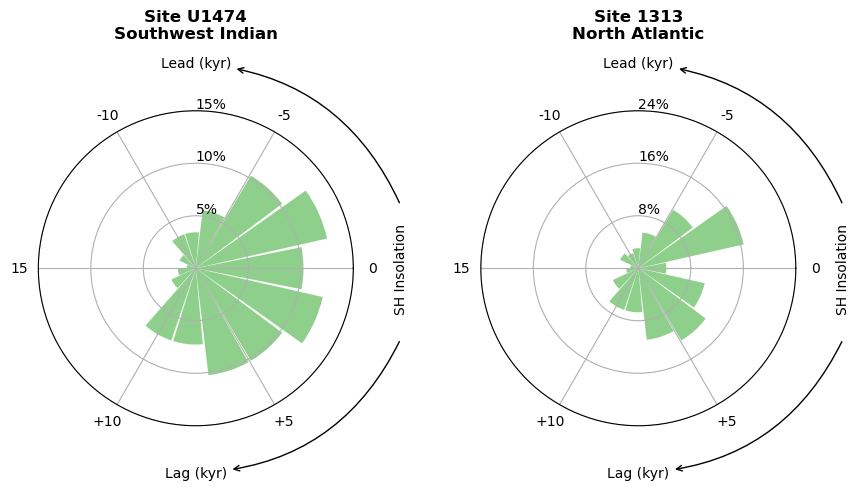

In [58]:
fig=plt.figure(figsize=(9,5),facecolor='w')
ax1 = fig.add_subplot(121, polar=True)
ax2 = fig.add_subplot(122, polar=True)
axes=[ax1,ax2]

### top titles
tags=['\nSouthwest Indian','\nNorth Atlantic']
for i,site in enumerate(['U1474','1313']):
    ax=axes[i]
    ax.set_title('Site '+site+tags[i],fontweight='bold',pad=52)

    
### Wheels
bins_list=[16,16]
type_list=['65smax Proximity','65smax Proximity','65smax Proximity']
sitenames=['U1474','1313']
offset_for_annots=[15,15]
rgrids=[[5,10,15],
        [8,16,24]]

for i,site in enumerate([agtU1474,agt1313]):
    
    max_type=type_list[i] 
    N=bins_list[i]
    type_insol=type_list[i]
    counts,edges=np.histogram(site[max_type].dropna(),bins=np.linspace(-12,12,N))
    ncounts=counts/counts.sum()*100
    ax=axes[i]
    
    edgesrarr=np.concatenate([edges[round(N/2)-1:],edges[:round(N/2)-1]])
    countsrarr=np.concatenate([ncounts[round(N/2)-1:],ncounts[:round(N/2)-1]])
    
    bottom = 0

    # theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    theta = np.linspace(0, 2 * np.pi, N-1, endpoint=False)
    radii = countsrarr
    width = (2*np.pi) / N

    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=greens_colors[2])

    # Use custom colors and opacity
#     for r, bar in zip(radii, bars):
#         bar.set_facecolor(plt.cm.Greens(r/radii.max()))
#         bar.set_alpha(0.9)
    
    rgrid=rgrids[i]
    ax.set_rgrids(rgrid, angle=90)
    xtick_loc = np.linspace(0, 2 * np.pi, 6, endpoint=False)
    ax.set_xticks(xtick_loc)
    ax.set_xticklabels(['0','-5','-10','15','+10','+5'])
    ax.set_yticklabels([str(rgrid[0])+'%',str(rgrid[1])+'%',str(rgrid[2])+'%'])
    
    sitename=sitenames[i]
    
    offset_for_annot=offset_for_annots[i]
    if i == 1:
        hemisphere='SH'
    else:
        hemisphere='SH'
    ax.annotate(hemisphere+' Insolation',xy=(1.15,.5),xycoords='axes fraction',rotation=90,ha='center',va='center')
    
    ax.annotate("Lead (kyr)",
            xy=(1.15, .7), xycoords='axes fraction',
            xytext=(.5, 1.15), textcoords='axes fraction', ha='center', va='center',
            arrowprops=dict(arrowstyle="<-",
                            connectionstyle="arc3,rad=-0.3"),
            )
    ax.annotate("Lag (kyr)",
            xy=(1.15, .275), xycoords='axes fraction',
            xytext=(.5, -.15), textcoords='axes fraction', ha='center', va='center',
            arrowprops=dict(arrowstyle="<-",
                            connectionstyle="arc3,rad=0.3"),
            )

plt.tight_layout()
plt.subplots_adjust(bottom=.12,top=.75)
fig.savefig(sup_figure_path+'Extended Data Figure 9 - Phasing of green layer formation with respect to insolation.png',dpi=300)